# Education in Slovakia

## Import packages

In [6]:
import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import display

import preprocessing

import os
import warnings
# TODO: uncomment before publishing
#warnings.filterwarnings('ignore')

## Import data

In [7]:
#TODO: change links before publishing
#data_root = 'https://raw.githubusercontent.com/AndruKP/mathprofi-education/dev/data'
data_root = './data'
url_010_SR = data_root + '/RV_O_010_R_SR_SK.CSV'
url_040_SR = data_root + '/RV_O_040_R_SR_SK.CSV'
url_040_OK = data_root + '/RV_O_040_L_OK_SK.CSV'
url_047_SR = data_root + '/RV_O_047_R_SR_SK.CSV'
url_067_SR = data_root + '/RV_O_067_R_SR_SK.CSV'

districts_url = 'https://bbrejova.github.io/viz/data/districts.json'

In [8]:
table_010_SR = pd.read_csv(url_010_SR, sep=';')
table_040_SR = pd.read_csv(url_040_SR, sep=';')
table_040_OK = pd.read_csv(url_040_OK, sep=';')
table_047_SR = pd.read_csv(url_047_SR, sep=';')
table_067_SR = pd.read_csv(url_067_SR, sep=';')

districts_table = gpd.read_file(districts_url)

display(table_010_SR.head())
display(table_040_SR.head())
display(table_040_OK.head())
display(table_047_SR.head())
display(table_067_SR.head())

display(districts_table.head())

,Kód štátu,Názov štátu,Pohlavie,Ekonomické vekové skupiny,Vzdelanie,abs.
0,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),nezistené,6301
1,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie (bližšie neuvedené),1
2,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 1. stupeň základnej školy,117157
3,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 2. stupeň základnej školy,66
4,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),bez ukončeného vzdelania – osoby vo veku 0-14 ...,320751


,Kód štátu,Názov štátu,Pohlavie,Vek,Vzdelanie,Súčasná ekonomická aktivita,abs.
0,SK0,Slovenská republika,muž,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,29036
1,SK0,Slovenská republika,muž,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30033
2,SK0,Slovenská republika,muž,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30808
3,SK0,Slovenská republika,muž,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,31100
4,SK0,Slovenská republika,muž,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30873


,Kód okresu,Názov okresu,Pohlavie,Vek,Vzdelanie,Súčasná ekonomická aktivita,abs.
0,SK0101,Okres Bratislava I,muž,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,229
1,SK0101,Okres Bratislava I,muž,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,263
2,SK0101,Okres Bratislava I,muž,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,281
3,SK0101,Okres Bratislava I,muž,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,270
4,SK0101,Okres Bratislava I,muž,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,246


,Kód štátu,Názov štátu,Pohlavie,5-ročné vekové skupiny,Vzdelanie,Zamestnanie (ISCO - triedy),abs.
0,SK0,Slovenská republika,muž,15 - 19 rokov,nezistené,nezistené,354
1,SK0,Slovenská republika,muž,15 - 19 rokov,nezistené,Odborní pracovníci v zdravotníctve,1
2,SK0,Slovenská republika,muž,15 - 19 rokov,nezistené,Administratívni pracovníci na záznam číselných...,1
3,SK0,Slovenská republika,muž,15 - 19 rokov,nezistené,Pracovníci v osobných službách,1
4,SK0,Slovenská republika,muž,15 - 19 rokov,nezistené,Predavači,1


,Kód štátu,Názov štátu,Súčasná ekonomická aktivita,Odvetvie ekonomickej činnosti​ (NACE - sekcie),Zamestnanie (ISCO - triedy),Vzdelanie,abs.
0,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,nezistené,5642
1,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie (bližšie neuvedené),7
2,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 1. stupeň základnej školy,702
3,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 2. stupeň základnej školy,3233
4,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,35


,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,LAU1_CODE,LAU2,LAU2_CODE,geometry
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0321,Badín,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00..."
1,Banská Štiavnica,2021-02-26 00:00:00+00:00,602,Banská Štiavnica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0322,Svätý Anton,SK0322516597,"POLYGON ((-440822.840 -1272799.420, -440809.15..."
2,Bardejov,2021-02-26 00:00:00+00:00,701,Bardejov,7,Prešovský,Východné Slovensko,SK04,Prešovský kraj,SK041,SK0411,Abrahámovce,SK0411519014,"POLYGON ((-251311.230 -1194615.930, -251463.13..."
3,Bratislava I,2021-02-26 00:00:00+00:00,101,Bratislava I,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0101,Bratislava-Staré Mesto,SK0101528595,"POLYGON ((-575659.050 -1277509.490, -575929.03..."
4,Bratislava II,2021-02-26 00:00:00+00:00,102,Bratislava II,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0102,Bratislava-Ružinov,SK0102529320,"POLYGON ((-564128.190 -1281777.370, -563932.30..."


## Preprocess data

In [9]:
# TODO: aggregate all preprocessing functions into one

table_010_SR = preprocessing.rename_columns(table_010_SR)
table_040_SR = preprocessing.rename_columns(table_040_SR)
table_040_OK = preprocessing.rename_columns(table_040_OK)
table_047_SR = preprocessing.rename_columns(table_047_SR)
table_067_SR = preprocessing.rename_columns(table_067_SR)

table_010_SR = preprocessing.translate_sex(table_010_SR)
table_040_SR = preprocessing.translate_sex(table_040_SR)
table_040_OK = preprocessing.translate_sex(table_040_OK)
table_047_SR = preprocessing.translate_sex(table_047_SR)
table_067_SR = preprocessing.translate_sex(table_067_SR)

table_040_SR.age = table_040_SR.age.apply(preprocessing.age_preprocess)
table_040_OK.age = table_040_OK.age.apply(preprocessing.age_preprocess)

display('table_010_SR:')
display(table_010_SR.head())
display('table_040_SR:')
display(table_040_SR.head())
display('table_040_OK:')
display(table_040_OK.head())
display('table_047_SR:')
display(table_047_SR.head())
display('table_067_SR:')
display(table_067_SR.head())

'table_010_SR:'

,NUTS1_CODE,state_name,sex,economical_age_groups,education,count
0,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),nezistené,6301
1,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie (bližšie neuvedené),1
2,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie - 1. stupeň základnej školy,117157
3,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie - 2. stupeň základnej školy,66
4,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),bez ukončeného vzdelania – osoby vo veku 0-14 ...,320751


'table_040_SR:'

,NUTS1_CODE,state_name,sex,age,education,current_economic_activity,count
0,SK0,Slovenská republika,male,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,29036
1,SK0,Slovenská republika,male,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30033
2,SK0,Slovenská republika,male,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30808
3,SK0,Slovenská republika,male,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,31100
4,SK0,Slovenská republika,male,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30873


'table_040_OK:'

,LAU1_CODE,district_name,sex,age,education,current_economic_activity,count
0,SK0101,Okres Bratislava I,male,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,229
1,SK0101,Okres Bratislava I,male,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,263
2,SK0101,Okres Bratislava I,male,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,281
3,SK0101,Okres Bratislava I,male,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,270
4,SK0101,Okres Bratislava I,male,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,246


'table_047_SR:'

,NUTS1_CODE,state_name,sex,year_5_age_groups,education,ISCO_occupation,count
0,SK0,Slovenská republika,male,15 - 19 rokov,nezistené,nezistené,354
1,SK0,Slovenská republika,male,15 - 19 rokov,nezistené,Odborní pracovníci v zdravotníctve,1
2,SK0,Slovenská republika,male,15 - 19 rokov,nezistené,Administratívni pracovníci na záznam číselných...,1
3,SK0,Slovenská republika,male,15 - 19 rokov,nezistené,Pracovníci v osobných službách,1
4,SK0,Slovenská republika,male,15 - 19 rokov,nezistené,Predavači,1


'table_067_SR:'

,NUTS1_CODE,state_name,current_economic_activity,NACE_section,ISCO_occupation,education,count
0,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,nezistené,5642
1,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie (bližšie neuvedené),7
2,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 1. stupeň základnej školy,702
3,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 2. stupeň základnej školy,3233
4,SK0,Slovenská republika,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,35


## Basic demographic analysis

### Population pyramid

In [10]:
grouped_by_sex_age = table_040_SR.groupby(['sex', 'age'])['count'].sum()
women_counts = grouped_by_sex_age.loc['female']
men_counts = grouped_by_sex_age.loc['male']

min_counts = np.minimum(men_counts, women_counts)

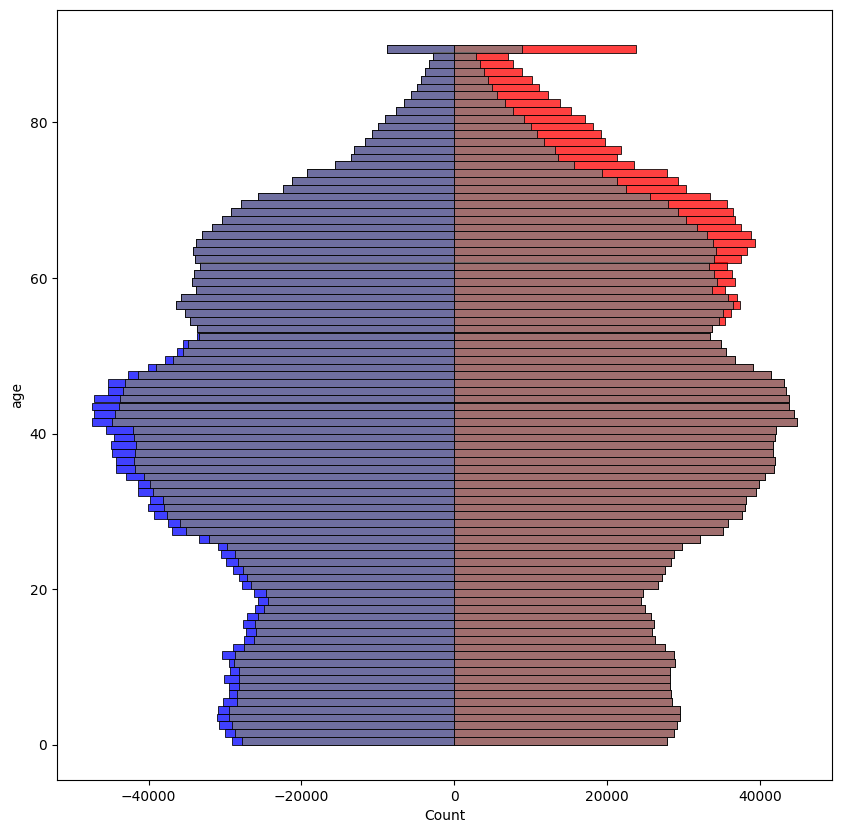

In [11]:
# TODO: legend and beauty
figure, axes = plt.subplots(figsize=(10, 10))

# Surplus
sns.histplot(y=women_counts.index, weights=women_counts, binwidth=1, color='red', ax=axes)
sns.histplot(y=men_counts.index, weights=-1 * men_counts, binwidth=1, color='blue', ax=axes)

# Population
sns.histplot(y=min_counts.index, weights=min_counts, binwidth=1, color='gray', ax=axes)
sns.histplot(y=min_counts.index, weights=-1 * min_counts, binwidth=1, color='gray', ax=axes)
pass

## Education analysis

### Education specialization

In [12]:
# TODO: someone's data (Sasha's idk)

In [13]:
# TODO: someone's graph (barplot idk)

### Geographic specialization of education

In [14]:
# TODO: Kolya's data

In [15]:
# TODO: Kolya's graphs

### Gender specialization of education

#### Gender distribution of education by gender

In [16]:
education_by_sex = table_047_SR.groupby(['sex', 'education'])['count'].sum()
education_by_sex = education_by_sex.reset_index()
education_by_sex.sort_values(by='count', ascending=False, inplace=True)
# TODO: is this sort based or cringe?
# TODO: aggregate categories by groups?

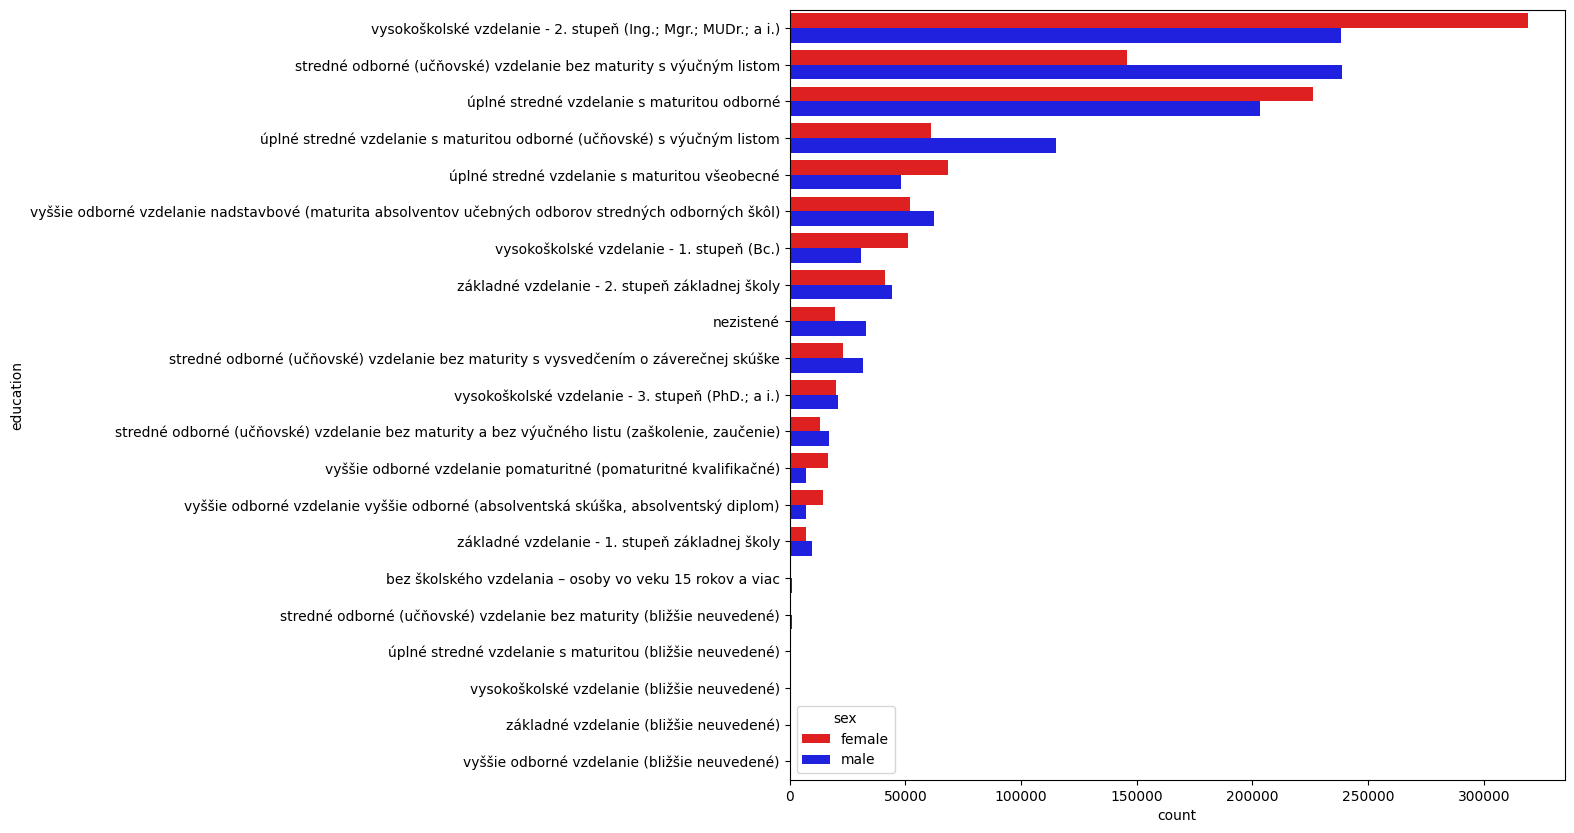

In [17]:
# TODO: beauty
figure, axes = plt.subplots(figsize=(10, 10))

sns.barplot(data=education_by_sex, y="education", x="count", hue="sex", palette=['red', 'blue'], ax=axes)
pass

In [18]:
# TODO: first hypothesis by Filip Kerak

### Adult illiteracy

#### Geographic aspect of illiteracy

In [19]:
districts_illiteracy = districts_table.set_index('LAU1_CODE')

table_OK_population = table_040_OK.groupby('LAU1_CODE')['count'].sum()

# TODO: uneducated filter applies twice -- introduce func
table_OK_uneducated = (table_040_OK
                       .query(
    'education == "bez školského vzdelania – osoby vo veku 15 rokov a viac" & current_economic_activity != "žiak základnej školy"')
                       .groupby(['LAU1_CODE'])['count']
                       .sum())

table_uneducated_ratio = table_OK_uneducated / table_OK_population

geotable_uneducated = gpd.GeoDataFrame(table_OK_uneducated, geometry=districts_illiteracy['geometry'])
geotable_uneducated_ratio = gpd.GeoDataFrame(table_uneducated_ratio, geometry=districts_illiteracy['geometry'])

display(table_OK_population.head(2))
display(geotable_uneducated.head(2))
display(geotable_uneducated_ratio.head(2))

LAU1_CODE
SK0101     46080
SK0102    125179
Name: count, dtype: int64

,count,geometry
LAU1_CODE,,
SK0101,25,"POLYGON ((-575659.050 -1277509.490, -575929.03..."
SK0102,163,"POLYGON ((-564128.190 -1281777.370, -563932.30..."


,count,geometry
LAU1_CODE,,
SK0101,0.000543,"POLYGON ((-575659.050 -1277509.490, -575929.03..."
SK0102,0.001302,"POLYGON ((-564128.190 -1281777.370, -563932.30..."


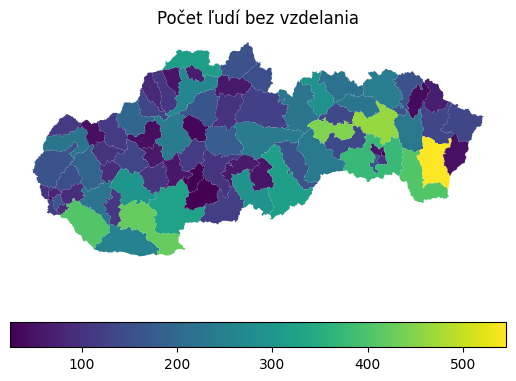

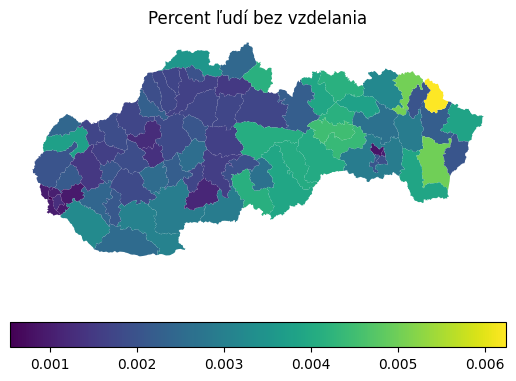

In [20]:
# TODO: beauty
plot = geotable_uneducated.plot(column='count', legend=True, legend_kwds={"orientation": "horizontal"})
plot.set_title("Počet ľudí bez vzdelania")
plot.set_axis_off()

plot = geotable_uneducated_ratio.plot(column='count', legend=True, legend_kwds={"orientation": "horizontal"})
plot.set_title("Percent ľudí bez vzdelania")
plot.set_axis_off()

In [21]:
#TODO: add description and map about Romani people

#### Employment of uneducated people

In [22]:
table_uneducated_by_isco = (table_067_SR
                            .query("education == 'bez školského vzdelania – osoby vo veku 15 rokov a viac'")
                            .groupby('ISCO_occupation')['count']
                            .sum()
                            .sort_values(ascending=False)
                            .reset_index())

unknown_occupation_count = table_uneducated_by_isco.query('ISCO_occupation == "nezistené"')['count'].sum()
inapplicable_occupation_count = table_uneducated_by_isco.query('ISCO_occupation == "neaplikovateľné"')['count'].sum()

applicable_occupation = table_uneducated_by_isco.query(
    'ISCO_occupation != "nezistené" & ISCO_occupation != "neaplikovateľné"')
applicable_occupation_count = applicable_occupation['count'].sum()

display(applicable_occupation.head())

,ISCO_occupation,count
2,Vodiči a obsluha pojazdných strojných zariadení,68
3,Operátori stacionárnych strojov a zariadení,67
4,Upratovači a pomocníci,63
5,Predavači,56
6,Kvalifikovaní stavební robotníci a remeselníci...,53


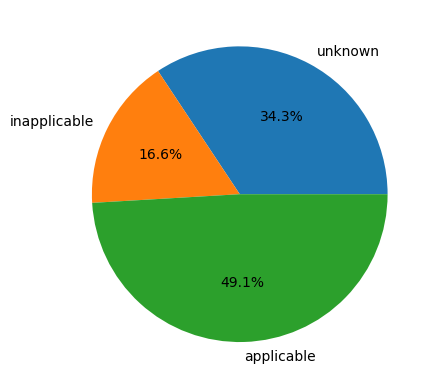

In [23]:
# TODO: beauty

plt.pie([unknown_occupation_count, inapplicable_occupation_count, applicable_occupation_count],
        labels=['unknown', 'inapplicable', 'applicable'], autopct='%1.1f%%')

plt.show()

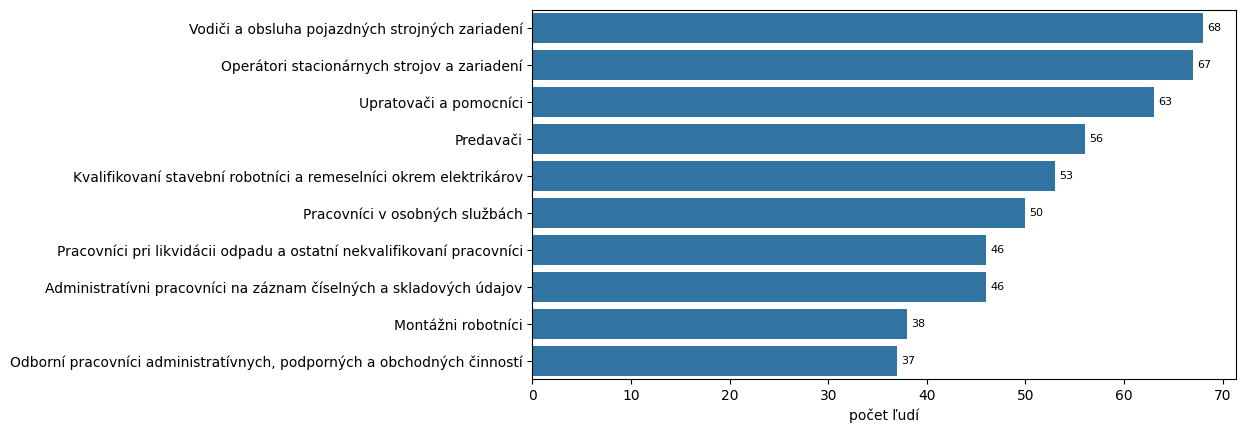

In [24]:
plot = sns.barplot(data=applicable_occupation.head(10), x='count', y='ISCO_occupation')
plot.bar_label(plot.containers[0], fontsize=8, padding=3)
plot.set_xlabel('počet ľudí')
plot.set_ylabel('')
plt.subplots_adjust(left=0.5, right=1.6)

#### Age distribution of illiteracy

In [25]:
table_SR_uneducated = (table_040_SR
.query(
    'education == "bez školského vzdelania – osoby vo veku 15 rokov a viac" & current_economic_activity != "žiak základnej školy"'))

#table = table[table['Vek'] != '90 a viac rokov']
#table['5-rocne skupiny'] = table['Vek'].apply(int).apply(f)

#table = pd.DataFrame(table.groupby('5-rocne skupiny')['abs.'].sum()).reset_index()
table_SR_uneducated

,NUTS1_CODE,state_name,sex,age,education,current_economic_activity,count
57,SK0,Slovenská republika,male,15,bez školského vzdelania – osoby vo veku 15 rok...,nezistené,58
105,SK0,Slovenská republika,male,16,bez školského vzdelania – osoby vo veku 15 rok...,nezistené,99
106,SK0,Slovenská republika,male,16,bez školského vzdelania – osoby vo veku 15 rok...,pracujúci (okrem dôchodcov),1
107,SK0,Slovenská republika,male,16,bez školského vzdelania – osoby vo veku 15 rok...,nezamestnaný,5
108,SK0,Slovenská republika,male,16,bez školského vzdelania – osoby vo veku 15 rok...,osoba v domácnosti,22
...,...,...,...,...,...,...,...
15842,SK0,Slovenská republika,female,86,bez školského vzdelania – osoby vo veku 15 rok...,dôchodca,23
15873,SK0,Slovenská republika,female,87,bez školského vzdelania – osoby vo veku 15 rok...,dôchodca,30
15905,SK0,Slovenská republika,female,88,bez školského vzdelania – osoby vo veku 15 rok...,dôchodca,20
15930,SK0,Slovenská republika,female,89,bez školského vzdelania – osoby vo veku 15 rok...,dôchodca,26


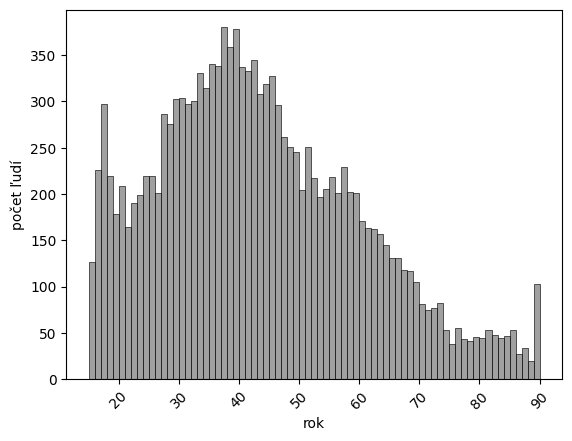

In [26]:
# TODO: beauty
plot = sns.histplot(data=table_SR_uneducated, x="age", weights="count", color='grey', binwidth=1)

plot.set_xlabel('rok')
plot.set_ylabel('počet ľudí')

plt.xticks(rotation=45)
plt.show()

## Employment analysis

### Employment specialization

In [ ]:
# TODO: someone's data (Sasha's idk)

In [ ]:
# TODO: someone's graph (barplot idk)

### Sectoral structure of the economy

In [ ]:
# TODO: data

In [ ]:
# TODO: graph

### Geographic specialization of economy

In [ ]:
# TODO: data

In [ ]:
# TODO: graph (asi Kolia)

### Analysis of unemployment

In [28]:
def calculate_counts(data):
    return data.groupby('year_5_age_groups').agg({
        'ISCO_occupation': lambda x: x.isna().sum(),
        'count': 'sum'
    }).rename(columns={'ISCO_occupation': 'NaN count', 'count': 'Total count'}).reset_index()

In [42]:
nan_age_groups = table_047_SR[table_047_SR['ISCO_occupation'] == 'nezistené']
not_nan_age_groups = table_047_SR[table_047_SR['ISCO_occupation'] != 'nezistené']

unemployed_table = calculate_counts(nan_age_groups)
employed_table = calculate_counts(not_nan_age_groups)

merged_table = pd.merge(employed_table, unemployed_table, on='year_5_age_groups', suffixes=('_employed', '_unemployed'))

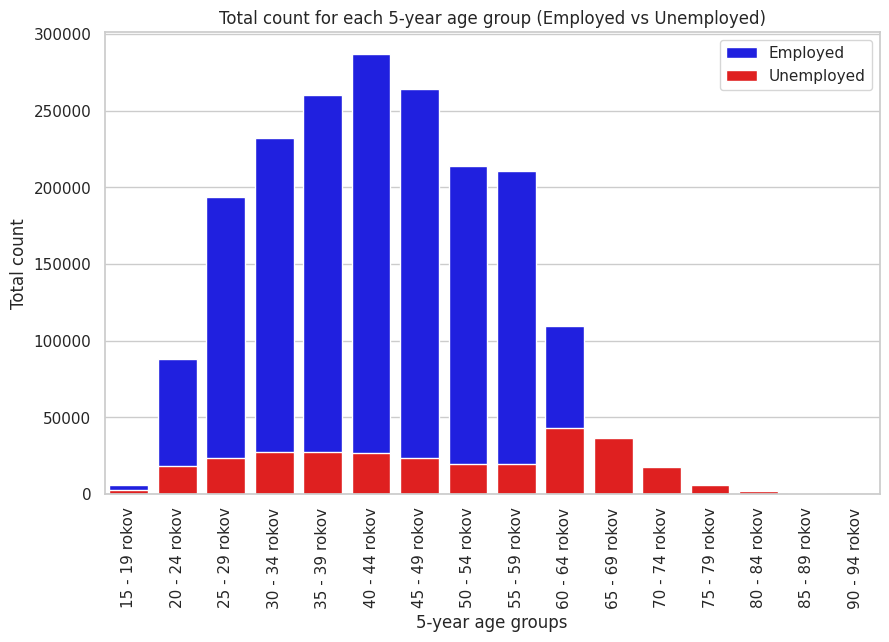

In [43]:
sns.set_style("whitegrid")
sns.set_context("notebook")
plt.figure(figsize=(10, 6))

sns.barplot(x='year_5_age_groups', y='Total count_employed', data=merged_table, color='blue', label='Employed')
sns.barplot(x='year_5_age_groups', y='Total count_unemployed', data=merged_table, color='red', label='Unemployed')

plt.xticks(rotation='vertical')
plt.xlabel('5-year age groups')
plt.ylabel('Total count')
plt.title('Total count for each 5-year age group (Employed vs Unemployed)')
plt.legend()

plt.savefig('Total_count_Employed_vs_Unemployed.png')
plt.show()

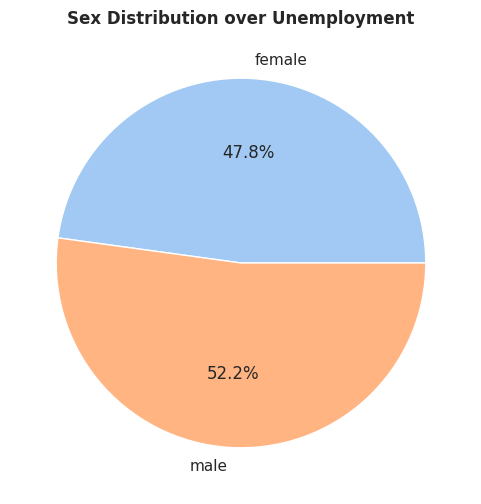

In [46]:
colors = sns.color_palette('pastel')[:2]
nan_age_groups_gender = nan_age_groups.groupby('sex')['count'].sum().reset_index()

plt.figure(figsize=(6,6))
plt.pie(x=nan_age_groups_gender['count'], labels=nan_age_groups_gender['sex'], autopct='%1.1f%%', colors = colors)
plt.title('Sex Distribution over Unemployment', fontweight='bold')
plt.show()

In [47]:
app = Dash(__name__)

age_group_options = [{'label': age_group, 'value': age_group} for age_group in nan_age_groups['year_5_age_groups'].unique()]

app.layout = html.Div([
    html.H1("Education vs. Unemployment by Age Group"),
    html.Label("Select Age Group(s)"),
    dcc.Dropdown(
        id='age-group-dropdown',
        options=age_group_options,
        value=[age_group_options[0]['value']],
        multi=True
    ),
    dcc.Checklist(
        id='include-no-education',
        options=[{'label': 'Include No education', 'value': 'no_education'}],
        value=['no_education']
    ),
    dcc.Graph(id='education-vs-unemployment-plot', style={'height': '800px'})
])

@app.callback(
    Output('education-vs-unemployment-plot', 'figure'),
    [Input('age-group-dropdown', 'value'),
     Input('include-no-education', 'value')]
)
def update_plot(selected_age_groups, include_no_education):
    filtered_data = nan_age_groups[nan_age_groups['year_5_age_groups'].isin(selected_age_groups)]
    if 'no_education' not in include_no_education:
        filtered_data = filtered_data[filtered_data['education'] != 'No education']

    aggregated_data = filtered_data.groupby(['education', 'year_5_age_groups'])['count'].sum().reset_index()

    sorted_education = aggregated_data.groupby('education')['count'].sum().sort_values(ascending=False).index

    fig = px.bar(aggregated_data, x='education', y='count', color='year_5_age_groups', barmode='group',
                 title='Education vs. Unemployment by Age Group', labels={'count': 'Total Count'},
                 category_orders={'education': sorted_education})
    return fig


if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

<IPython.core.display.Javascript object>

## Interactive section

In [ ]:
# TODO: powerful graph Nikolai i <3 u

In [ ]:
# TODO: powerful graph Nikolai i <2 u

In [ ]:
# TODO: powerful graph Nikolai i <1 u